## IMDB predictor supported by MLFlow 

This notebook is demonstration whot to use MLFlow to track experiments, store artifacts and use stored data using Tensorbord

http://188.246.227.23:5000/#/models

Make sure you have configured environment variables: 

* `MLFLOW_TRACKING_URI` should point to MLFLOW ui 
* `MLFLOW_S3_ENDPOINT_URL` should point to S3 endpoint (if it is not s3)

You can use `mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])` to configure mlflow uri explicitly 

In [1]:
# Params
import os
from checksumdir import dirhash
DATA_SOURCE = os.environ.get('IMDB_DATA_SOURCE', '../data/prep')
PROJECT_NAME = '/mlflow/imdb'

 # Only consider the top 20k words
MAX_FEATURES = 20000
# Only consider the first 200 words of each movie review
MAXLEN = 200
TRAIN_MD5 = dirhash(DATA_SOURCE, 'md5')
print(f'Training data: {DATA_SOURCE}, md5 hash: {TRAIN_MD5}')

Training data: ../data/prep, md5 hash: bae676a21d9f12c2af6bd9cbec43de3a


## Load data and train/test split

In [2]:
import pandas as pd
import string

def remove_punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))

def normalize(s):
    return s.lower()

def prep_pipeline(s):    
    s = remove_punctuation(s)
    s = normalize(s)
    return s

assert prep_pipeline('AFD sf.s dfsdf;') == 'afd sfs dfsdf'

data_df = pd.read_csv(os.path.join(DATA_SOURCE, 'train.csv'), index_col='Id')
data_df.Review = data_df.Review.apply(prep_pipeline)
data_df.Expected = data_df.Expected.apply(lambda x: int(x=='pos'))

from sklearn.model_selection import train_test_split
x_train_text, x_val_text, y_train, y_val = train_test_split(data_df.Review, 
                                                            data_df.Expected, 
                                                            test_size=0.33, 
                                                            random_state=42, 
                                                            stratify=data_df.Expected)

# TODO: add test set 
#test_df = pd.read_csv('../data/prep/test.csv')

print(f'{len(x_train_text)} Training samples')
print(f'{len(x_val_text)} Validation samples')

16750 Training samples
8250 Validation samples


## Tokenize

In [3]:
from tensorflow import keras
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_FEATURES, filters='', lower=False, split=' ')
tokenizer.fit_on_texts(x_train_text)

x_train_sequence = tokenizer.texts_to_sequences(x_train_text)
x_train = keras.preprocessing.sequence.pad_sequences(x_train_sequence, maxlen=MAXLEN)

x_val_sequence = tokenizer.texts_to_sequences(x_val_text)
x_val = keras.preprocessing.sequence.pad_sequences(x_val_sequence, maxlen=MAXLEN)

## Build machine learning model

In [4]:
import numpy as np
from tensorflow.keras import layers

def create_model(max_features, maxlen):
    # Input for variable-length sequences of integers
    inputs = keras.Input(shape=(None,), dtype="int32")
    # Embed each integer in a 128-dimensional vector
    x = layers.Embedding(max_features, 128)(inputs)
    # Add 2 bidirectional LSTMs
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(64))(x)
    # Add a classifier
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    return model

In [21]:
import tempfile
import mlflow
import mlflow.pyfunc
import tensorflow as tf

def log_model(artifact_path, python_model, tf_model):

    from platform import python_version
    import cloudpickle
    
    conda_env = {
        'channels': ['defaults', 'conda-forge'],
        'dependencies': [
            f'python={python_version()}',
            'pip', 
            {
                'pip': [
                    f'tensorflow=={tf.__version__}',
                    f'cloudpickle=={cloudpickle.__version__}'
                ]
            }
        ],
        'name': 'imdb_env'
    }

    tf_model_path = 'model.h5'
    tf_model.save(tf_model_path)

    artifacts = {
        'tf_model': tf_model_path
    }

    mlflow.pyfunc.log_model(artifact_path=artifact_path, 
                         python_model=python_model, 
                         artifacts=artifacts, 
                         conda_env=conda_env)

class ImdbModel(mlflow.pyfunc.PythonModel):
    def __init__(self, prep_pipeline, tokenizer, maxlen, threshold):
        # You can pass pipelines using constructor, they will be serialized
        self.prep_pipeline = prep_pipeline
        self.tokenizer = tokenizer
        self.maxlen = maxlen
        self.threshold = threshold
    
    def load_context(self, context):
        from tensorflow import keras
        self.tf_model = keras.models.load_model(context.artifacts['tf_model'])
        
    def predict(self, context, model_input):
        model_input.Review = model_input.Review.apply(self.prep_pipeline)
        x = self.tokenizer.texts_to_sequences(model_input.Review)
        x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen)
        y_pred = self.tf_model.predict(x)
        y_pred = ((y_pred + self.threshold)//1).astype('int64')
        return y_pred



import numpy as np
import matplotlib
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion_matrix', normalize=None):
    x_labels, y_lables = labels, labels
    
    mx = confusion_matrix(y_true, y_pred, normalize=normalize)

    fig, ax = plt.subplots()
    im = ax.imshow(mx)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_lables)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_lables)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(x_labels)):
        for j in range(len(y_lables)):
            text = ax.text(j, i, mx[i, j], ha="center", va="center", color="w")

    ax.set_title(title)
    fig.tight_layout()

## Run experiment (MLFlow here)

In [15]:
import mlflow, os
import mlflow.tensorflow
from sklearn.metrics import confusion_matrix

In [7]:
experiment = mlflow.get_experiment_by_name(PROJECT_NAME)
if experiment:
    experiment_id = experiment.experiment_id
else:
    # Possible to set up own s3 bucket artifact_location
    experiment_id = mlflow.create_experiment(name=PROJECT_NAME)
print(f'Active experiment_id: {experiment_id}')

Active experiment_id: 3


D:\Soft\Anaconda\envs\aiprocess\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


2/2 [==============================] - 35s 17s/step - loss: 0.6950 - accuracy: 0.4400 - val_loss: 0.6930 - val_accuracy: 0.5004


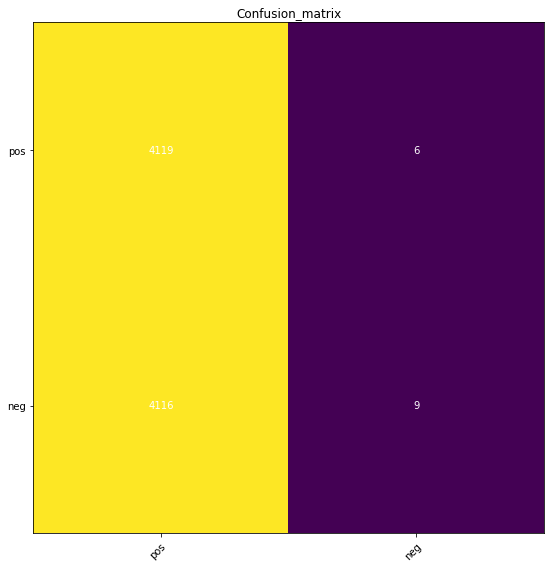

Experiment info: <RunInfo: artifact_uri='s3://mlflow/artefacts/3/4447ee2cc47548fda081420ee208af71/artifacts', end_time=None, experiment_id='3', lifecycle_stage='active', run_id='4447ee2cc47548fda081420ee208af71', run_uuid='4447ee2cc47548fda081420ee208af71', start_time=1595715003729, status='RUNNING', user_id='Ihar_Nestsiarenia'>


<Figure size 576x576 with 0 Axes>

In [18]:
with mlflow.start_run(experiment_id=experiment_id):
    
    # Log data hash (key-value pair)
    mlflow.log_param("train_md5", TRAIN_MD5)

    tf_model = create_model(max_features=MAX_FEATURES, maxlen=MAXLEN)
    tf_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
    mlflow.tensorflow.autolog()
    tf_model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val))
    
    imdb_model = ImdbModel(prep_pipeline=prep_pipeline, tokenizer=tokenizer, maxlen=MAXLEN, threshold=0.5)
    
    # Log a metric; metrics can be updated throughout the run
    # mlflow.log_metric("foo", 3, step=1)
    
    # Store binary model
    imdb_model_path = 'imdb_model'
    log_model(artifact_path=imdb_model_path, 
              python_model=imdb_model,
              tf_model=tf_model)
    
    # Test model
    loaded_model = mlflow.pyfunc.load_model(f'{mlflow.active_run().info.artifact_uri}/{imdb_model_path}')
    y_val_pred = loaded_model.predict(pd.DataFrame(x_val_text))
    
    # Log confusion matrix 
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"]=8,8
    
    plot_confusion_matrix( y_true=y_val, y_pred=y_val_pred, labels=['pos', 'neg'])
    plt.savefig('confusion_matrix.png')
    mlflow.log_artifact('confusion_matrix.png')
    
    # Show experiment metadata
    experiment = mlflow.get_experiment(experiment_id)
    print(f'Experiment info: {mlflow.active_run().info}')

## Tensorboard (Optional)

Run tensorboard instance 

Example:

``` 
tensorboard --logdir s3://mlflow/artefacts/0/70251c20a0a74b63af9cddcefe7d5313/artifacts/tensorboard_logs
```

And go to: 

http://localhost:6006/ 

In [23]:
from tensorboard import notebook
# View open TensorBoard instances
notebook.list()

No known TensorBoard instances running.


In [19]:
# notebook.display(port=6006, height=1000)